In [11]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from scipy.spatial import ConvexHull
pd.options.mode.chained_assignment = None  # default='warn'
# import scann
import math
import seaborn as sns
import multiprocessing

In [12]:
def parrallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))

In [13]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed bin widths
def trimDF(df,x,y,percentiles,bins,binwidth):
    for i in range (len(bins)-1):
        data = df.loc[abs(df[x]-bins[i])<binwidth[i]]
        if not data.empty:
            df = df.drop(data.loc[(data[y]<np.percentile(data[y], percentiles[0]))].index.values)
            df = df.drop(data.loc[(data[y]>np.percentile(data[y], percentiles[1]))].index.values)
    return df



In [14]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed sample sizesd
def trimDFNumSample(df,x,y,percentiles,bins,numsamples):
    # sort DF by the x value to speed up subsetting
    dropList = []
    sortList = df.sort_values(by=x).reset_index()
    for i in bins:
        # find location of value nearest to current bin
        binIndex = sortList.loc[sortList[x]>i].index
        if not binIndex.empty:
            lenList = len(sortList)
            Sample = sortList.iloc[(np.maximum((binIndex[0]-100),0)):(np.minimum((binIndex[0]+100), lenList))]
            if not Sample.empty:
                dropList.append(Sample.loc[Sample[y]<np.percentile(Sample[y],percentiles[0])]['index'].values.tolist()) 
                dropList.append(Sample.loc[Sample[y]>np.percentile(Sample[y],percentiles[1])]['index'].values.tolist())
    return df.drop(sum(dropList,[]))


In [15]:
def reduce_func(D_chunk, start):
    return np.histogram(D_chunk)

In [16]:
# does lars regression , displays path and returns results
def showLarsPath(X,y):
    
    alphas, active, coefs = linear_model.lars_path(X=X,y=y, method="lars", verbose=True)
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim(ylims)()
    plt.vlines(xx, ymin, ymax, linestyle="dashed")
    plt.xlabel("|coef| / max|coef|")
    plt.ylabel("Coefficients")
    plt.title("LASSO Path")
    plt.axis("tight")
    plt.show()
    
    return alphas, active, coefs

In [17]:
def parseSamples(directoryPath,fileSuffix):

    file_name = ['LUTinputLC0XB36', 'LUTinputLC0XB45','LUTinputMOD09' ,'LUTinputLC0XLat', \
                 'LUTinputLC0XLon','LUToutputLC0X','YearLC0X','MonthLC0X', \
                 'DayLC0X','PathLC0X','RowLC0X','FparLai_QC','FparExtra_QC']

    dataset = []
    DataList = []
    count = 0

    for name in file_name:
        dataset.append(f'{directoryPath}{name}{fileSuffix}')

    for name_dataset in dataset:
        with open(f'{name_dataset}', 'rb') as fp1:
            objs = []
            while 1:
                try:
                    objs.append(pickle.load(fp1))
                except EOFError:
                    break
            DataList = [item for sublist in objs for item in sublist]

        if count == 0:
            LUTB36_list = DataList
        elif count == 1:
            LUTB45_list = DataList
        elif count == 2:
            LUTMOD09_list = DataList
        elif count == 3:
            LUTLat = DataList
        elif count == 4:
            LUTLon = DataList
        elif count == 5:
            LUToutput_list = DataList
        elif count == 6:
            LUTyear = DataList
        elif count == 7:
            LUTmonth = DataList
        elif count == 8:
            LUTday = DataList
        elif count == 9:
            LUTpath = DataList
        elif count == 10:
            LUTrow = DataList
        elif count == 11:
            LUTQC= DataList
        elif count == 12:
            LUTQCextra = DataList
        count = count + 1

    print('LUTB36_list:', len(LUTB36_list))
    print('LUTB45_list:', len(LUTB45_list))
    print('LUTMOD09_list:', len(LUTMOD09_list))
    print('LUTLat:', len(LUTLat))
    print('LUTLon:', len(LUTLon))
    print('LUToutput_list:', len(LUToutput_list))
    print('LUTyear:', len(LUTyear))
    print('LUTmonth:', len(LUTmonth))
    print('LUTday:', len(LUTday))
    print('LUTpath:', len(LUTpath))
    print('LUTrow:', len(LUTrow))

    # parse the LUTs into Pandas tables
    LUT_Lai = np.double(np.floor(np.mod(LUToutput_list,1e2)/1e0))
    LUT_LaiStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e4)/1e2)))
    LUT_Fpar = np.double(np.floor(np.mod(LUToutput_list,1e6))/1e4)
    LUT_FparStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e8)/1e6)))
    # LUT_satFlag = np.uint64(np.floor(np.mod(LUToutput_list,1e11))/1e9)
    # LUT_snowFlag = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e14)/1e12)))
    LUT_LC_Type3 = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e16)/1e14)))
    LUT_satFlag = (np.array(LUTQC)== 32).astype(int)
    LUT_snowFlag =  (((np.array(LUTQCextra)== 4).astype(int)+(np.array(LUTQCextra)== 132).astype(int))>0).astype(int)


    LUT_SR_B3 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e3)/1)))
    LUT_SR_B4 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e3)/1)))

    LUT_SR_B5 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e6)/1e3)))
    LUT_SR_B6 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e6)/1e3)))
    LUT_VIEW_ZENITH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e8)/1e6)))
    LUT_VIEW_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e11)/1e8)))
    LUT_SUN_ELEVATION = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e13)/1e11)))
    LUT_SUN_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e16)/1e13)))

    LUT_MOD09_red = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e4)/1)))
    LUT_MOD09_NIR = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e8)/1e4)))
    LUT_MSUN_ZENITH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e10)/1e8)))
    LUT_MSUN_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e13)/1e10)))
    LUT_MVIEW_ZENITH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e15)/1e13)))
    LUT_MVIEW_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e18)/1e15)))
    
    # make pandas frame of all coded inputs
    return pd.DataFrame( {'year':LUTyear, 'month': LUTmonth, 'day': LUTday, 'path':LUTpath, 'row':LUTrow,\
                          'Lat':LUTLat, 'Lon':LUTLon, 'input36': LUTB36_list,'input45':LUTB45_list, 'inputMOD09': LUTMOD09_list, 'redMODIS': LUT_MOD09_red,'NIRMODIS': LUT_MOD09_NIR,\
                          'green':LUT_SR_B3 * 10, 'red':LUT_SR_B4 * 10, 'NIR': LUT_SR_B5 * 10, 'SWIR1': LUT_SR_B6 * 10,   \
                          'SensorZenith':LUT_VIEW_ZENITH, 'SensorAzimuth': LUT_VIEW_AZIMUTH, 'SolarZenith':LUT_SUN_ELEVATION, 'SolarAzimuth': LUT_SUN_AZIMUTH, \
                          'M_sensor_zenith':LUT_MVIEW_ZENITH, 'M_sensor_azimuth': LUT_MVIEW_AZIMUTH, 'M_sun_zenith':LUT_MSUN_ZENITH, 'M_sun_azimuth': LUT_MSUN_AZIMUTH, \
                          'LC_type3': LUT_LC_Type3, 'output': LUToutput_list,'LAI': LUT_Lai, 'stdLAI': LUT_LaiStdDev, 'FAPAR': LUT_Fpar, 'stdFAPAR': LUT_FparStdDev,\
                          'LUT_satFlag': LUT_satFlag,'LUT_snowFlag': LUT_snowFlag,'LC_type3': LUT_LC_Type3}) \
               .sort_values('input36')

In [18]:
# trim calibration data based on comparing Landsat and MODIS equivalents
# note we oversample the MODIS axis as we trim
# this takes some time

def trimDF(df):

    # histogram NDVI vs LAI
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')
    plt.show()
    # threshold based on red MODIS
    df = df.drop(df.loc[(df['redMODIS']<100)].index.values)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')
    plt.show()

    # trim based on red
    #df = trimDF(df,'redMODIS','red',[10,90],np.arange(0.0,1000.0,10),np.arange(0,1000,10)*0+20)
    df = trimDFNumSample(df,'redMODIS','red',[10,90],np.arange(100,1000.0,10),10000)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')
    plt.show()
    #trim based on nir
    #df = trimDF(df,'NIRMODIS','NIR',[10,90],np.arange(0.0,10000.0,100),np.arange(0,10000,100)*0+200)
    df = trimDFNumSample(df,'NIRMODIS','NIR',[10,90],np.arange(100,1000.0,10),10000)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')
    plt.show()
    
    #trim based on nir
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['LAI'], gridsize=(50,50), extent=(0,10000,0,100))
    ax1.set(xlabel='redMODIS', ylabel='LAI')
    ax2.hexbin(df['NIRMODIS'],df['LAI'], gridsize=(50,50), extent=(0,10000,0,100))
    ax2.set(xlabel='NIRMODIS', ylabel='LAI')
    plt.show()
    return df

In [19]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResults(df,xlims,ylims,tval,bwidth):
    fig, axes = plt.subplots(2,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    

    predictions = np.array(df['rf1RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[0,0],
        data=df, x='rf1RawLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth,cmap='turbo'
    )
    axes[0,0].plot(xlims,ylims)
    axes[0,0].set_xlim(xlims)
    axes[0,0].set_ylim(ylims)


    predictions = np.array(df['rf2RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[0,1],
         data=df, x='rf2RawLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth,cmap='turbo'
    )
    axes[0,1].plot(xlims,ylims)
    axes[0,1].set_xlim(xlims)
    axes[0,1].set_ylim(ylims)


    predictions = np.array(df['rf3RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[0,2],
         data=df, x='rf3RawLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth,cmap='turbo'
    )
    axes[0,2].plot(xlims,ylims)
    axes[0,2].set_xlim(xlims)
    axes[0,2].set_ylim(ylims)

    predictions = np.array(df['rf4RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[0,3],
         data=df, x='rf4RawLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth,cmap='turbo'
    )
    axes[0,3].plot(xlims,ylims)
    axes[0,3].set_xlim(xlims)
    axes[0,3].set_ylim(ylims)
    
#     predictions = np.array(df['rf1AllLAI'])
#     targets = np.array(df['LAI'])
#     print(np.sqrt(np.mean((predictions-targets)**2)))
#     sns.histplot(ax=axes[1,0],
#         data=df, x='rf1AllLAI', y='LAI',
#         bins=30, discrete=(False, False), log_scale=(False, False),
#         thresh=tval,binwidth=bwidth,cmap='turbo'
#     )
#     axes[1,0].plot(xlims,ylims)
#     axes[1,0].set_xlim(xlims)
#     axes[1,0].set_ylim(ylims)


#     predictions = np.array(df['rf2AllLAI'])
#     targets = np.array(df['LAI'])
#     print(np.sqrt(np.mean((predictions-targets)**2)))
#     sns.histplot(ax=axes[1,1],
#          data=df, x='rf2AllLAI', y='LAI',
#         bins=30, discrete=(False, False), log_scale=(False, False),
#         thresh=tval,binwidth=bwidth,cmap='turbo'
#     )
#     axes[1,1].plot(xlims,ylims)
#     axes[1,1].set_xlim(xlims)
#     axes[1,1].set_ylim(ylims)


#     predictions = np.array(df['rf3AllLAI'])
#     targets = np.array(df['LAI'])
#     print(np.sqrt(np.mean((predictions-targets)**2)))
#     sns.histplot(ax=axes[1,2],
#          data=df, x='rf3AllLAI', y='LAI',
#         bins=30, discrete=(False, False), log_scale=(False, False),
#         thresh=tval,binwidth=bwidth,cmap='turbo'
#     )
#     axes[1,2].plot(xlims,ylims)
#     axes[1,2].set_xlim(xlims)
#     axes[1,2].set_ylim(ylims)

#     predictions = np.array(df['rf4AllLAIW'])
#     targets = np.array(df['LAI'])
#     print(np.sqrt(np.mean((predictions-targets)**2)))
#     sns.histplot(ax=axes[1,3],
#          data=df, x='rf4AllLAIW', y='LAI',
#         bins=30, discrete=(False, False), log_scale=(False, False),
#         thresh=tval,binwidth=bwidth,cmap='turbo'
#     )
#     axes[1,3].plot(xlims,ylims)
#     axes[1,3].set_xlim(xlims)
#     axes[1,3].set_ylim(ylims)
    
    plt.show()
    return

In [20]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResultsCond(df,datarange,nbins,gamma):
    fig, ax = plt.subplots(2,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    fig.tight_layout()
    
    predictions = np.array(df['rf1RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    condHist = (np.histogram2d(predictions,targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,0].plot(x, y, color="white", linewidth=1)
    f1=ax[0,0].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,0],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,0].plot(xvalues, res ,'w.', label='Accuracy')


    predictions = np.array(df['rf2RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    condHist = (np.histogram2d(predictions,targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,1].plot(x, y, color="white", linewidth=1)
    f1=ax[0,1].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,1],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,1].plot(xvalues, res ,'w.', label='Accuracy')

    predictions = np.array(df['rf3RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    condHist = (np.histogram2d(predictions,targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,2].plot(x, y, color="white", linewidth=1)
    f1=ax[0,2].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,2],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,2].plot(xvalues, res ,'w.', label='Accuracy')
    
    predictions = np.array(df['rf4RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    condHist = np.histogram2d(predictions,targets, bins=nbins, range=datarange, normed=None, weights=None, density=None)
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,3].plot(x, y, color="white", linewidth=1)
    f1=ax[0,3].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,3],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,3].plot(xvalues, res ,'w.', label='Accuracy')   

    plt.show()
    return

In [21]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResidualsCond(df,datarange,nbins,gamma):
    fig, ax = plt.subplots(2,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    fig.tight_layout()
    
    predictions = np.array(df['rf1RawLAI'])
    targets = np.array(df['LAI'])
    condHist = (np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,0].plot(x, 0*y, color="white", linewidth=1)
    f1=ax[0,0].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,0],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,0].plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax[0,0].plot(xvalues, unc ,'r.', label='Uncertainty')  

    predictions = np.array(df['rf2RawLAI'])
    targets = np.array(df['LAI'])
    condHist = (np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,1].plot(x, 0*y, color="white", linewidth=1)
    f1=ax[0,1].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,1],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,1].plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax[0,1].plot(xvalues, unc ,'r.', label='Uncertainty')  

    predictions = np.array(df['rf3RawLAI'])
    targets = np.array(df['LAI'])
    condHist = (np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,2].plot(x, 0*y, color="white", linewidth=1)
    f1=ax[0,2].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,2],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,2].plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax[0,2].plot(xvalues, unc ,'r.', label='Uncertainty')  
       
    predictions = np.array(df['rf4RawLAI'])
    targets = np.array(df['LAI'])
    condHist = np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None)
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,3].plot(x, 0*y, color="white", linewidth=1)
    f1=ax[0,3].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,3],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,3].plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax[0,3].plot(xvalues, unc ,'r.', label='Uncertainty')  
    
    plt.show()
    return

In [22]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResidualsCond2(df,datarange,nbins,gamma):
    fig, ax = plt.subplots(2,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    fig.tight_layout()
    
    predictions = np.array(df['rf1RawLAI'])
    targets = np.array(df['LAI'])
    condHist = (np.histogram2d(predictions,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,0].plot(x, 0*y, color="white", linewidth=1)
    f1=ax[0,0].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,0],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,0].plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax[0,0].plot(xvalues, unc ,'y.', label='Accuracy')  


    predictions = np.array(df['rf2RawLAI'])
    targets = np.array(df['LAI'])
    condHist = (np.histogram2d(predictions,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,1].plot(x, 0*y, color="white", linewidth=1)
    f1=ax[0,1].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,1],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,1].plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax[0,1].plot(xvalues, unc ,'r.', label='Uncertainty')  

    predictions = np.array(df['rf3RawLAI'])
    targets = np.array(df['LAI'])
    condHist = (np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,2].plot(x, 0*y, color="white", linewidth=1)
    f1=ax[0,2].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,2],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,2].plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax[0,2].plot(xvalues, unc ,'r.', label='Uncertainty')  
    
    predictions = np.array(df['rf4RawLAI'])
    targets = np.array(df['LAI'])
    condHist = np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None)
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax[0,3].plot(x, 0*y, color="white", linewidth=1)
    f1=ax[0,3].imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax[0,3],fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax[0,3].plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax[0,3].plot(xvalues, unc ,'r.', label='Uncertainty')    
    
    plt.show()
    return

In [23]:
def makeFeatures(df):

    df['green1'] = np.clip((df.loc[:,"green"]),0,3000)/10000
    df['red1'] = np.clip((df.loc[:,"red"]),0,3000)/10000
    df['NIR1'] = np.clip((df.loc[:,"NIR"]),0,5000)/10000
    df['SWIR11'] = np.clip((df.loc[:,"SWIR1"]),0,5000)/10000
    df['ISR'] = np.clip((df.loc[:,"NIR1"])/np.maximum(df.loc[:,"SWIR11"],.0001),0,3)
    df['SR'] = np.clip((df.loc[:,"NIR1"])/np.maximum(df.loc[:,"red1"],.0001),0,20)
    df['GI'] = np.clip((df.loc[:,"green1"])/np.maximum(df.loc[:,"red1"],.0001),0,3)
    df['GVI'] = np.clip((df.loc[:,"NIR1"])/np.maximum(df.loc[:,"green1"]-1,.0001),0,20)
    df['NDVI'] = np.clip(((df.loc[:,"NIR1"])-(df.loc[:,"red1"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"red"])),.0001),0,+1)
    df['GNDVI'] = np.clip(((df.loc[:,"NIR1"])-(df.loc[:,"green1"]))/np.maximum(((df.loc[:,"NIR1"])+(df.loc[:,"green1"])),.0001),0,+1)
    df['NDWI'] = np.clip(((df.loc[:,"NIR1"])-(df.loc[:,"SWIR11"]))/np.maximum(((df.loc[:,"NIR1"])+(df.loc[:,"SWIR11"])),.0001),0,+1)
    df['NDGI'] = np.clip(((df.loc[:,"green1"])-(df.loc[:,"red1"]))/np.maximum(((df.loc[:,"green1"])+(df.loc[:,"red1"])),.0001),0,+1)       
    df['EVI'] = np.clip((2.5*((df.loc[:,"NIR1"])-(df.loc[:,"red1"]))/np.maximum((df.loc[:,"NIR1"])+6*(df.loc[:,"red1"])-7.5*(df.loc[:,"green1"])+1,.0001)),0,+1)
    df['EVI2'] = np.clip(2.4*((df.loc[:,"NIR1"])-(df.loc[:,"red1"]))/np.maximum(((df.loc[:,"NIR1"])+(df.loc[:,"red1"])+1),.0001),0,+1)
    df['RDVI'] = np.clip(((df.loc[:,"NIR1"])-(df.loc[:,"red1"]))/np.maximum(((df.loc[:,"NIR1"])+(df.loc[:,"red1"]))**0.5,.0001),0,+1)
    df['MSR'] = np.clip((((df.loc[:,"NIR1"])/(np.maximum(df.loc[:,"red1"],0.0001)))-1)/np.maximum((np.maximum((df.loc[:,"NIR1"])/np.maximum(df.loc[:,"red1"],0.0001),0.0001)**0.5+1),.0001),0,+1)
    df['MSAVI2'] = np.clip(0.5*(((df.loc[:,"NIR1"])+1)-np.maximum((2*(df.loc[:,"NIR1"])+1)**2-8*(df.loc[:,"NIR1"])-(df.loc[:,"red1"]),0.0001)**0.5),0,+1)
    df['NLI'] =np.clip(((df.loc[:,"NIR1"])**2-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR1"])**2+(df.loc[:,"red1"])),.0001),0,+1)
    return df

LUTB36_list: 6792058
LUTB45_list: 6792058
LUTMOD09_list: 6792058
LUTLat: 6792058
LUTLon: 6792058
LUToutput_list: 6792058
LUTyear: 6792058
LUTmonth: 6792058
LUTday: 6792058
LUTpath: 6792058
LUTrow: 6792058


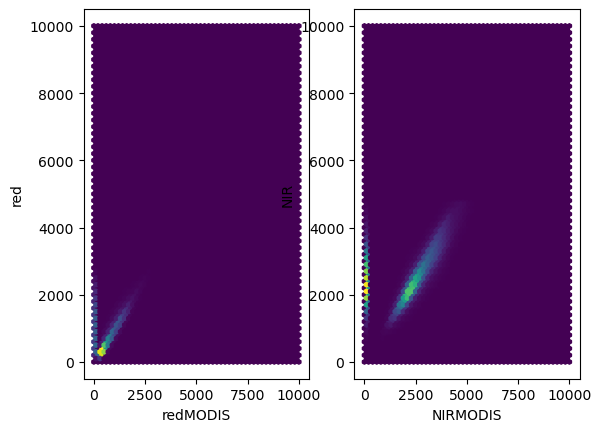

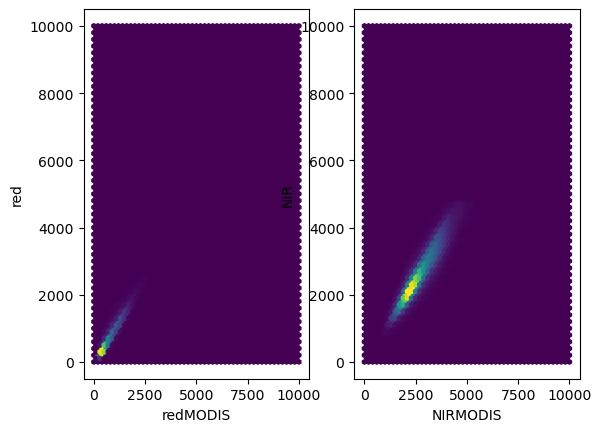

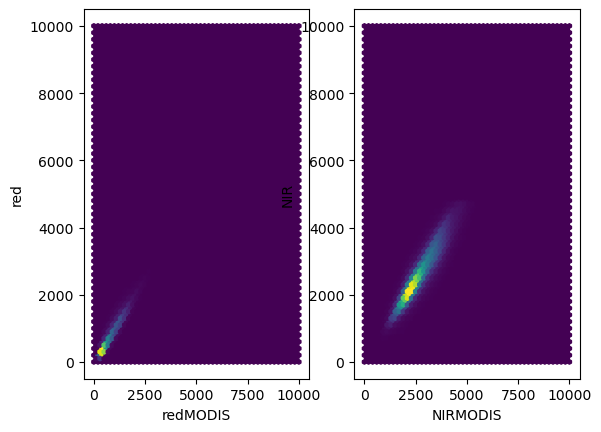

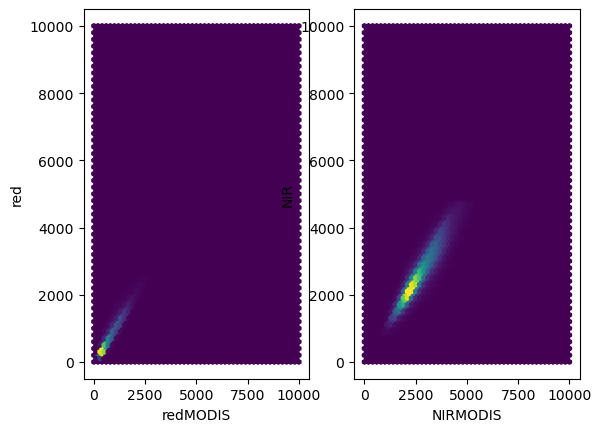

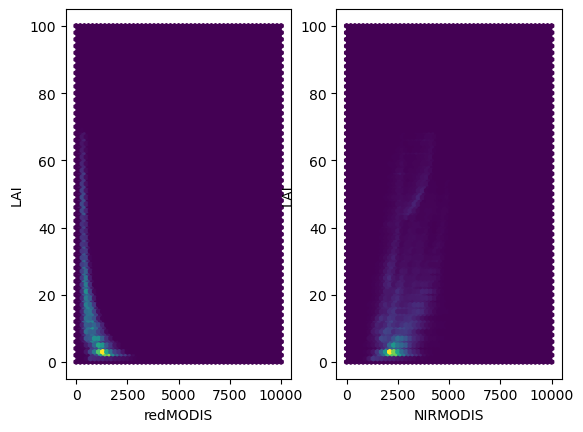

In [41]:
directoryPath  = '/home/richard_fernandes/modislandsat/Calibrationv5/NorthAmerica/'
fileSuffix = 'calv7'
calDFALL = parseSamples(directoryPath ,fileSuffix)
calDFALL = calDFALL[(calDFALL.LUT_snowFlag == 0) & (calDFALL.red > 0) & (calDFALL.green > 0 ) & (calDFALL.NIR > 0 ) & (calDFALL.red < np.quantile(calDFALL.red,0.99)) & (calDFALL.green < np.quantile(calDFALL.green,0.99)) \
                    & (calDFALL.NIR < np.quantile(calDFALL.NIR,0.995)) & (calDFALL.SWIR1 < np.quantile(calDFALL.SWIR1,0.99)) & (calDFALL.M_sensor_zenith<20)]
calDFALL = trimDF(calDFALL)


In [42]:
directoryPath  = '/home/richard_fernandes/modislandsat/Calibrationv6/NorthAmerica/'
fileSuffix = 'calv20'
valDFALL = parseSamples(directoryPath ,fileSuffix)
valDFALL = valDFALL[(valDFALL.LUT_snowFlag ==0) & (valDFALL.red > 0) & (valDFALL.green > 0 ) & (valDFALL.NIR > 0 ) & (valDFALL.red < np.quantile(valDFALL.red,0.99)) & (valDFALL.green < np.quantile(valDFALL.green,0.99)) \
                    & (valDFALL.NIR < np.quantile(valDFALL.NIR,0.99)) & (valDFALL.SWIR1 < np.quantile(valDFALL.SWIR1,0.99)) & (valDFALL.M_sensor_zenith<20)]
#ensure val and cal DF are different
df_all = valDFALL.merge(calDFALL.drop_duplicates(), on=valDFALL.columns, how='left', indicator=True)
valDFALL = df_all[df_all['_merge'] == 'left_only']
valDFALL = trimDF(valDFALL)
print(valDFALL.shape)

LUTB36_list: 7894093
LUTB45_list: 7894093
LUTMOD09_list: 7894093
LUTLat: 7894093
LUTLon: 7894093
LUToutput_list: 7894093
LUTyear: 7894093
LUTmonth: 7894093
LUTday: 7894093
LUTpath: 7894093
LUTrow: 7894093


KeyError: Index(['year', 'month', 'day', 'path', 'row', 'Lat', 'Lon', 'input36',
       'input45', 'inputMOD09', 'redMODIS', 'NIRMODIS', 'green', 'red', 'NIR',
       'SWIR1', 'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth',
       'M_sensor_zenith', 'M_sensor_azimuth', 'M_sun_zenith', 'M_sun_azimuth',
       'LC_type3', 'output', 'LAI', 'stdLAI', 'FAPAR', 'stdFAPAR',
       'LUT_satFlag', 'LUT_snowFlag'],
      dtype='object')

Supplementary Figure showing trimming

In [ ]:
# make features of all data
calDFALL = makeFeatures(calDFALL)
valDFALL = makeFeatures(valDFALL)

fig,ax = plt.subplots(2,2)
fig.set_figheight(5)
fig.set_figwidth(20)

im=ax[0,0].hexbin(calDFALL.loc[calDFALL['LUT_satFlag']==0,'Lon'],calDFALL.loc[calDFALL['LUT_satFlag']==0,'Lat'], gridsize=(50,50), extent=(-180,0,0,90),bins='log')
ax[0,0].set_xlabel('Lat',size = 12)
ax[0,0].set_ylabel('Lon',size = 12)
ax[0,0].set_title('Unsaturated Calibration Sample Density')


im=ax[0,1].hexbin(valDFALL.loc[valDFALL['LUT_satFlag']==0,'Lon'],valDFALL.loc[valDFALL['LUT_satFlag']==0,'Lat'], gridsize=(50,50), extent=(-180,0,0,90),bins='log')
ax[0,1].set_xlabel('Lat',size = 12)
ax[0,1].set_ylabel('Lon',size = 12)
fig.colorbar(im)
ax[0,1].set_title('Unsaturated  Validation Sample Density')

im=ax[1,0].hexbin(calDFALL.loc[calDFALL['LUT_satFlag']==1,'Lon'],calDFALL.loc[calDFALL['LUT_satFlag']==1,'Lat'], gridsize=(50,50), extent=(-180,0,0,90),bins='log')
ax[1,0].set_xlabel('Lat',size = 12)
ax[1,0].set_ylabel('Lon',size = 12)
ax[1,0].set_title('Saturated Calibration Sample Density')


im=ax[1,1].hexbin(valDFALL.loc[valDFALL['LUT_satFlag']==1,'Lon'],valDFALL.loc[valDFALL['LUT_satFlag']==1,'Lat'], gridsize=(50,50), extent=(-180,0,0,90),bins='log')
ax[1,1].set_xlabel('Lat',size = 12)
ax[1,1].set_ylabel('Lon',size = 12)
fig.colorbar(im)
ax[1,1].set_title('Saturated  Validation Sample Density')

plt.show()

Figure 1.  Density of all samples in study area (continental US and Canada) on log scale. 

In [28]:
calDF7 = calDFALL[calDFALL['LC_type3']==7]
print(calDF7.shape)
valDF7 = valDFALL[valDFALL['LC_type3']==7]
print(valDF7.shape)


(105233, 50)
(146075, 50)


In [19]:
allfeatures=  ['SR', 'ISR', 'green1', 'red1', 'NIR1', 'SWIR11', 'GI', 'GVI','NDVI','GNDVI','NDWI','NDGI','EVI','EVI2','RDVI','MSR','MSAVI2','NLI','SolarAzimuth','SolarZenith','SensorZenith','SensorAzimuth']
allBands = ['SR', 'ISR', 'green1', 'red1', 'NIR1', 'SWIR11', 'GI', 'GVI','NDVI','GNDVI','NDWI','NDGI','EVI','EVI2','RDVI','MSR','MSAVI2','NLI']
rawfeatures = ['green1', 'red1', 'NIR1', 'SWIR11','SolarAzimuth','SolarZenith']
response= ['LAI']

In [20]:
print(list(calDFALL))

['year', 'month', 'day', 'path', 'row', 'Lat', 'Lon', 'input36', 'input45', 'inputMOD09', 'redMODIS', 'NIRMODIS', 'green', 'red', 'NIR', 'SWIR1', 'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth', 'M_sensor_zenith', 'M_sensor_azimuth', 'M_sun_zenith', 'M_sun_azimuth', 'LC_type3', 'output', 'LAI', 'stdLAI', 'FAPAR', 'stdFAPAR', 'LUT_satFlag', 'LUT_snowFlag', 'green1', 'red1', 'NIR1', 'SWIR11', 'ISR', 'SR', 'GI', 'GVI', 'NDVI', 'GNDVI', 'NDWI', 'NDGI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI']


In [21]:
#uniform subsample of a dataframe based on a single feature after discarding extreme quantiles
#samples have an average minimum distance 
def uniformSampler(df,feature, randSeed,minDistance,minQuantile,maxQuantile,stepSize):


    # determine quantile range 
    lowerBound = np.quantile(df[feature],minQuantile)
    upperBound = np.quantile(df[feature],maxQuantile)
    
    # determine number of samples
    nsam = np.ceil((((upperBound-lowerBound)/minDistance))**0.5 + 1).astype(int)

    grid = np.random.default_rng().uniform(low=lowerBound, high=upperBound ,size=nsam).reshape(-1,1)
    jitter = np.random.default_rng().uniform(low=-stepSize/2, high=stepSize/2 ,size=df.shape[0]).reshape(-1,1)
    
    # find nearest neighbor matches , we first add random value to the feature to avoid multiple matches

    distances,indices = neighbors.NearestNeighbors(n_neighbors=1,n_jobs=-1).fit(np.array(df[feature].add(jitter)).reshape(-1,1)).kneighbors(grid)
    return df.iloc[np.unique(np.array(indices).ravel())]   



def ScaNN(train,test,k,numleaves,numleavestosearch,anisotropicquantizationthreshold,reorderSize) :

    # use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
    searcher = scann.scann_ops_pybind.builder(train, 1, "squared_l2").tree(
        num_leaves=numleaves,num_leaves_to_search=numleavestosearch, training_sample_size=train.shape[0]).score_ah(
        2, anisotropic_quantization_threshold=anisotropicquantizationthreshold).reorder(reorderSize).build()
    
    return searcher.search_batched(test)
    
# sets up a Sobol sampling grid and finds one match in df within a distance of each Sobol grid sample
#upper limit of 2^maxSobolOrder samples
def sobolSampler(df,featureColumns,densityfeature,maxSamples,randSeed,pairwiseDist,exact):
    
    # sobol sampling with number of samples determined by https://www.sciencedirect.com/science/article/abs/pii/S0378475406002382
    nsam = np.power(pairwiseDist,-len(featureColumns))
    M = np.uint16(np.ceil(np.log2(min(nsam,maxSamples))))
    sobel = scipy.stats.qmc.Sobol(len(featureColumns),seed=randSeed).random_base2(m=M)
    
    # match sobol samples to our data
    if exact==True:
        distances,indices = neighbors.NearestNeighbors(n_neighbors=1, n_jobs=-1, algorithm='ball_tree').fit(df[featureColumns]).kneighbors(sobel)
    else:
        indices, distances = ScaNN(df[featureColumns],sobel,k=1,numleaves=math.ceil(pow(pow(2,M),0.5)),numleavestosearch=100,anisotropicquantizationthreshold=0.2,reorderSize=100)
    indices = np.unique(np.array(indices).ravel())
    print(indices.size)
    print(maxSamples)
    print('number of sobol points, number of samples',indices.size,min(indices.size,maxSamples))

    return df.iloc[indices].sort_values([densityfeature]).head(min(indices.size,maxSamples)) 

# get minimum pairwise distances between rows in data frame
def getMinPairwiseDist(df,maxSamples, metricDist):
    
    nsam = min(maxSamples,df.shape[0])
    di = pairwise_distances(df.sample(nsam),n_jobs=-1,metric=metricDist)

    return np.amin(di+np.diag(np.ones(di.shape[0])+100),axis=1)

#

In [258]:
# fit models and make predictions for calibration and validation data

#define raw features and response
# rawfeatures = ['green1', 'red1', 'NIR1', 'SWIR11','SolarAzimuth','SolarZenith']
# response = ['LAI'] 
# responseString = 'LAI'
# anglefeatures = ['SolarAzimuth','SolarZenith']
# spectralfeatures = ['green1', 'red1', 'NIR1', 'SWIR11']
# kangfeatures = ['green1', 'red1', 'NIR1', 'SWIR11','SolarAzimuth','SolarZenith','Lat','Lon','NDVI','NDWI']
# # scale calibration and validation features between 0 and 1 based on calibration data
# calDFang = calDF7
# scalerDF = MinMaxScaler().fit(calDFang[rawfeatures])
# calDFang[rawfeatures] = pd.DataFrame(scalerDF.transform(calDFang[rawfeatures]),columns = calDFang[rawfeatures].columns, index =calDFang[allfeatures].index) 

# valDFang = valDF7
# valDFang[rawfeatures] = pd.DataFrame(scalerDF.transform(valDFang[rawfeatures]),columns = valDFang[rawfeatures].columns, index =valDFang[allfeatures].index) 

# # get density of features
# rawFreaturesKDE1 = neighbors.KernelDensity(bandwidth=0.01,kernel='gaussian',atol = 1e-8,rtol=1e-6).fit(calDFang[rawfeatures])
# calDFang['kde'] =  parrallel_score_samples(rawFreaturesKDE1, calDFang[rawfeatures])

# # # k NN regression , not usedin paper but a good best case solution
# knnRegressionModelRaw = neighbors.KNeighborsRegressor(n_neighbors=3,weights='distance',n_jobs=-1,algorithm='ball_tree').fit(calDFang[rawfeatures],calDFang[response])
# calDFang['rf1RawLAI']= knnRegressionModelRaw.predict(calDFang[rawfeatures])
# valDFang['rf1RawLAI']= knnRegressionModelRaw.predict(valDFang[rawfeatures])


# # #Rndom forest using empirical distribution
rfRaw1 = RandomForestRegressor(n_estimators=2,min_samples_leaf=10,bootstrap=True,random_state=0,verbose=0).fit(calDFang[rawfeatures], np.array(calDFang[response]).ravel())
calDFang['rf1RawLAI']=rfRaw1.predict(calDFang[rawfeatures])
valDFang['rf1RawLAI']=rfRaw1.predict(valDFang[rawfeatures])

# gradient boosted regressor using empirical distribution
rfRaw2 = GradientBoostingRegressor(n_estimators=100,min_samples_leaf=10,random_state=0,verbose=0,max_depth=30).fit(calDFang[rawfeatures], np.array(calDFang[response]).ravel())
calDFang['rf2RawLAI']=rfRaw2.predict(calDFang[rawfeatures])
valDFang['rf2RawLAI']=rfRaw2.predict(valDFang[rawfeatures])


# # # uniform subsampling of response random forest
# # # minDistance determines the approximate mean minimum distance between uniform sample points
# # # stePSize sets a tolerance for matches in the empirical sample to the uniform sample points
# # # minQuantile and maxQuantile set the upper and lower bounds on the uniform sample 
# randSeed=1 
# minDistance = 0.00000001
# minQuantile = 0.01
# maxQuantile = 0.99
# stepSize=1
# subSampleDF1 = uniformSampler(calDFang,response, randSeed,minDistance,minQuantile,maxQuantile,stepSize)
# rawFreaturesKDE2 = neighbors.KernelDensity(bandwidth=0.01,kernel='gaussian',atol = 1e-8,rtol=1e-6).fit(subSampleDF1[rawfeatures])
# subSampleDF1['kde'] =  parrallel_score_samples(rawFreaturesKDE2, subSampleDF1[rawfeatures])
# rf2Raw = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(subSampleDF1[rawfeatures], np.array(subSampleDF1[response]).ravel())
# calDFang['rf2RawLAI']=rf2Raw.predict(calDFang[rawfeatures])
# valDFang['rf2RawLAI']=rf2Raw.predict(valDFang[rawfeatures])


# # kang et al. method
# # uniform subsampling of response + balancing of sat and unsat samples random forest
# numSat = subSampleDF1.loc[subSampleDF1['LUT_satFlag']==1].shape[0]
# numUnsat = subSampleDF1.loc[subSampleDF1['LUT_satFlag']==0].shape[0]
# subSampleDFKang = subSampleDF1
# # subSampleDFKang = pd.concat(subSampleDF1.loc[subSampleDF1['LUT_satFlag']==0].sample(min(numSat,numUnsat)),subSampleDF1.loc[subSampleDF1['LUT_satflag']==1].sample(min(numSat,numUnsat)))
# rf3Raw = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(subSampleDFKang[kangfeatures], np.array(subSampleDFKang[response]).ravel())
# calDFang['rf3RawLAI']=rf3Raw.predict(calDFang[kangfeatures])
# valDFang['rf3RawLAI']=rf3Raw.predict(valDFang[kangfeatures])

# # # FTL 
# # # functional transfer learning based on partitioning calibration reature sdpace into maxClass regions of uniform density and applying
# # # separate ranndom forest regressors to each partition
# # #
# # # The partition class is saved as column classDF
# maxPairwiseDistance = np.quantile(getMinPairwiseDist(calDFang.loc[calDFang['kde'] < np.quantile(calDFang['kde'],0.10),rawfeatures],maxSamples=10000,metricDist='euclidean'),0.95)
# subSampleDF2a = sobolSampler(calDFang,rawfeatures,densityfeature='kde',maxSamples=530000,randSeed=1,pairwiseDist=maxPairwiseDistance,exact=True)
# convexHullDF = calDFang.reset_index().iloc[ConvexHull(calDFang[rawfeatures]).vertices]
# lowResponseDF = calDFang.loc[(calDFang[responseString]<np.quantile(calDFang[responseString],0.10))]
# highResponseDF = calDFang.loc[(calDFang[responseString]>np.quantile(calDFang[responseString],0.90))]
# subSampleDF2 = pd.concat([subSampleDF2a, convexHullDF,lowResponseDF,highResponseDF])
# rawFreaturesKDE2 = neighbors.KernelDensity(bandwidth=0.01,kernel='gaussian',atol = 1e-8,rtol=1e-6).fit(subSampleDF2[rawfeatures])
# subSampleDF2['kde'] =  parrallel_score_samples(rawFreaturesKDE2, subSampleDF2[rawfeatures])

# maxClasses = 20
# rf4Raw = RandomForestRegressor(n_estimators=1,min_samples_leaf=500,bootstrap=False,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=maxClasses).fit(subSampleDF2[rawfeatures], np.array(subSampleDF2[response]).ravel())
# calDFang['classRF'] = (rf4Raw.predict(calDFang[rawfeatures])*100).astype(int)
# valDFang['classRF'] = (rf4Raw.predict(valDFang[rawfeatures])*100).astype(int)

# classValues = calDFang['classRF'].unique()
# for classLabel in classValues:
#     # augment with convex hull 
#     DF = calDFang.loc[calDFang['classRF']==classLabel]
#     X = DF[rawfeatures]
#     y = np.ravel(np.array(DF[response]))
#     clf = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(X,y)
#     X = calDFang.loc[calDFang['classRF']==classLabel,rawfeatures]
#     calDFang.loc[calDFang['classRF']==classLabel,'rf4RawLAI'] = clf.predict(X)    
#     X = valDFang.loc[valDFang['classRF']==classLabel,rawfeatures]
#     y = np.ravel(np.array(valDFang.loc[valDFang['classRF']==classLabel,response]))
#     valDFang.loc[valDFang['classRF']==classLabel,'rf4RawLAI'] = clf.predict(X)    



In [248]:
#[estimator.tree_.max_depth for estimator in rfRaw1.estimators_]
# [estimator.tree_.node_count for estimator in rfRaw1.estimators_]

#[estimator[0].tree_.max_depth for estimator in rfRaw2.estimators_]
[estimator[0].tree_.node_count for estimator in rfRaw2.estimators_]

[16185,
 16211,
 16223,
 16251,
 16225,
 16311,
 16203,
 16369,
 16207,
 16215,
 16257,
 16193,
 16285,
 16255,
 16157,
 16161,
 16135,
 16165,
 15665,
 15537,
 15727,
 15057,
 15357,
 15029,
 15389,
 14311,
 13937,
 13943,
 13527,
 13153,
 12533,
 11737,
 12715,
 11795,
 11831,
 11529,
 9225,
 8783,
 9449,
 7685,
 7991,
 8137,
 6559,
 7453,
 5753,
 6221,
 6341,
 7641,
 4455,
 3491,
 3949,
 3335,
 4819,
 4751,
 3539,
 2285,
 2851,
 1251,
 4161,
 3347,
 3145,
 5535,
 4743,
 1359,
 4723,
 719,
 763,
 1145,
 1473,
 4485,
 1021,
 431,
 755,
 333,
 639,
 407,
 245,
 533,
 2727,
 197,
 3205,
 1609,
 1209,
 363,
 687,
 835,
 1435,
 1099,
 157,
 405,
 159,
 413,
 635,
 319,
 407,
 701,
 365,
 273,
 335,
 265]

In [43]:
numSat = subSampleDF1.loc[subSampleDF1['LUT_satFlag']==1].shape[0]
numUnsat = subSampleDF1.loc[subSampleDF1['LUT_satFlag']==0].shape[0]
print(numSat)
print(numUnsat)
print(min(0,44859))

0
44859
0


In [ ]:
fig,axes = plt.subplots(3,4)
fig.set_figheight(20)
fig.set_figwidth(20)

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[0,0],data=calDFang, x='red',y='NIR', hue='kde2',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[0,0].get_legend().remove()
axes[0,0].set_title('All Data')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[0,1],data=subSampleDF1, x='red',y='NIR', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[0,1].get_legend().remove()
axes[0,1].set_title('Uniform Subsample Response')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[0,2],data=subSampleDFKang, x='red',y='NIR', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[0,2].get_legend().remove()
axes[0,2].set_title('Kang Subsample Response')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[0,3],data=subSampleDF2, x='red',y='NIR', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[0,3].get_legend().remove()
axes[0,3].set_title('Uniform Subsample Regressors')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[1,0],data=calDFang, x='red',y='SWIR1', hue='kde2',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[1,0].get_legend().remove()
axes[1,0].set_title('All Data')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[1,1],data=subSampleDF1, x='red',y='SWIR1', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[1,1].get_legend().remove()
axes[1,1].set_title('Uniform Subsample Response')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[1,2],data=subSampleDFKang, x='red',y='SWIR1', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[1,2].get_legend().remove()
axes[1,2].set_title('Kang Subsample Response')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[1,3],data=subSampleDF2, x='red',y='SWIR1', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[1,3].get_legend().remove()
axes[1,3].set_title('Uniform Subsample Regressors')


norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[2,0],data=calDFang, x='SolarZenith',y='SolarAzimuth', hue='kde2',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[2,0].get_legend().remove()
axes[2,0].set_title('All Data')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[2,1],data=subSampleDF1, x='SolarZenith',y='SolarAzimuth', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[2,1].get_legend().remove()
axes[2,1].set_title('Uniform Subsample Response')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[2,2],data=subSampleDFKang, x='SolarZenith',y='SolarAzimuth', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[2,2].get_legend().remove()
axes[2,2].set_title('Kang Subsample Response')

norm = plt.Normalize(np.quantile(subSampleDF2['kde'],.001), np.quantile(subSampleDF2['kde'],.99))
sm = plt.cm.ScalarMappable(cmap='turbo', norm=norm)
sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[2,3],data=subSampleDF2, x='SolarZenith',y='SolarAzimuth', hue='kde',palette='turbo',size=0.1, linewidth=0,alpha=0.75)
axes[2,3].get_legend().remove()
axes[2,3].figure.colorbar(sm)
axes[2,3].set_title('Uniform Subsample Regressors')

plt.show

Figure 2.  Scatter plots of sample feature space density for different subsampling schemes.  

In [ ]:
# figure 3 scatter plots of FTL RF classes in feature space

fig,axes = plt.subplots(3,4)
fig.set_figheight(20)
fig.set_figwidth(20)


sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[0,0],data=calDFang, x='red',y='NIR', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[0,0].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[0,1],data=calDFang, x='red',y='SWIR1', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[0,1].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[0,2],data=calDFang, x='red',y='SolarZenith', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[0,2].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[0,3],data=calDFang, x='red',y='SolarAzimuth', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[0,3].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[1,0],data=calDFang, x='SWIR1',y='NIR', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[1,0].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[1,1],data=calDFang, x='SWIR1',y='SolarZenith', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[1,1].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[1,2],data=calDFang, x='SWIR1',y='SolarAzimuth', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[1,2].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[2,0],data=calDFang, x='NIR',y='SolarZenith', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[2,0].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[2,1],data=calDFang, x='NIR',y='SolarAzimuth', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[2,1].get_legend().remove()

sm.set_array([])
sm.set_array([])
sns.scatterplot(ax=axes[2,2],data=calDFang, x='SolarZenith',y='SolarAzimuth', hue='classRF',palette='tab10',size=0.1, linewidth=0,alpha=0.75)
axes[2,2].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

In [107]:
import numpy.matlib
df = calDFang
nbins = 5
datarange = [[0,60],[0,60]]
predictions = np.array(df['rf1RawLAI'])
targets = np.array(df['LAI'])
print(np.sqrt(np.mean((predictions-targets)**2)))
condHist = (np.histogram2d(predictions,targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
x = condHist[1]
y = condHist[2]
dataHist = np.transpose(condHist[0])
dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
print(dataHist.shape)
# print(xvalues)
xArray = np.matlib.repmat(np.transpose(xvalues),dataHist.shape[1],1)
# print(xArray)
# print(dataHist)
# print(dataHist * xArray)
print(np.sum(dataHist * xArray,0))

7.0710262780869755
(5, 5)
[ 5.9999988  17.99999923 29.99999913 41.99999834 53.99998907]


Figure 3.  Scatter plots of sample feature space unique FTL RF Labels.

7.071053564478968
3.824308961351578
8.33883150881793
7.132718967698923


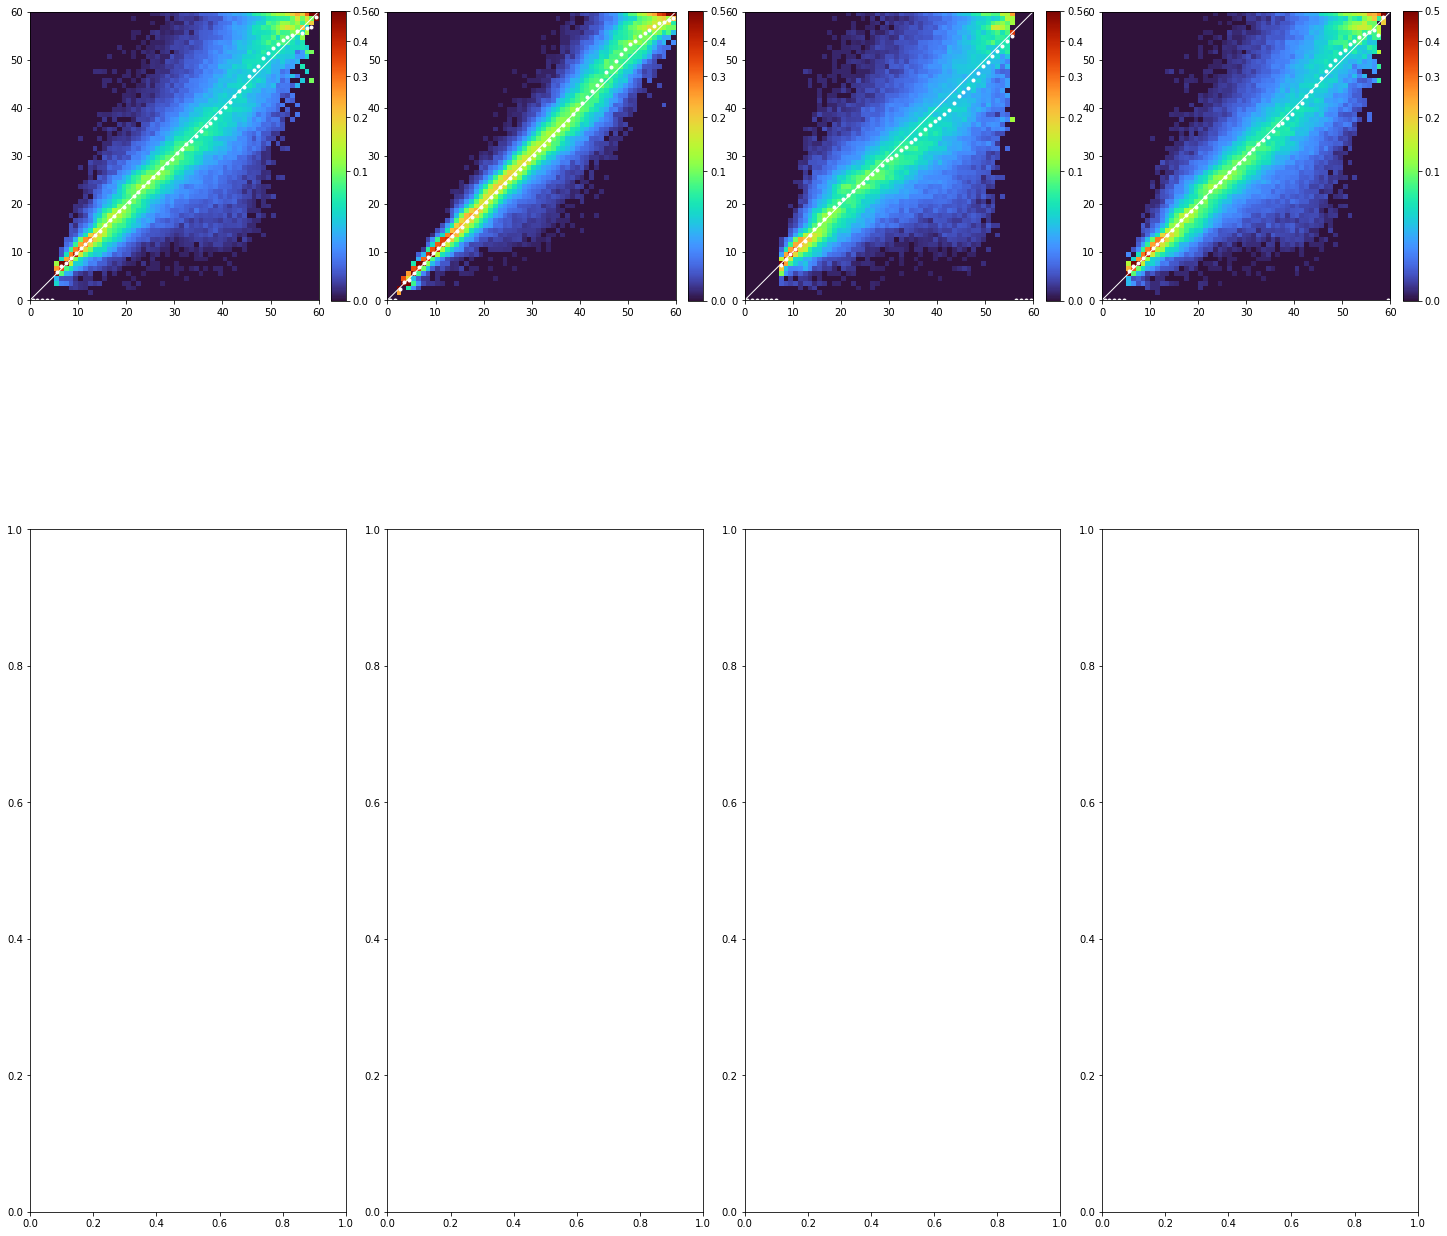

In [226]:
plotHistResultsCond(calDFang,[[0,60],[0,60]],nbins=60,gamma=0.5)



8.817093150459296
9.338765707789964
8.880569598190762
8.847413371539645


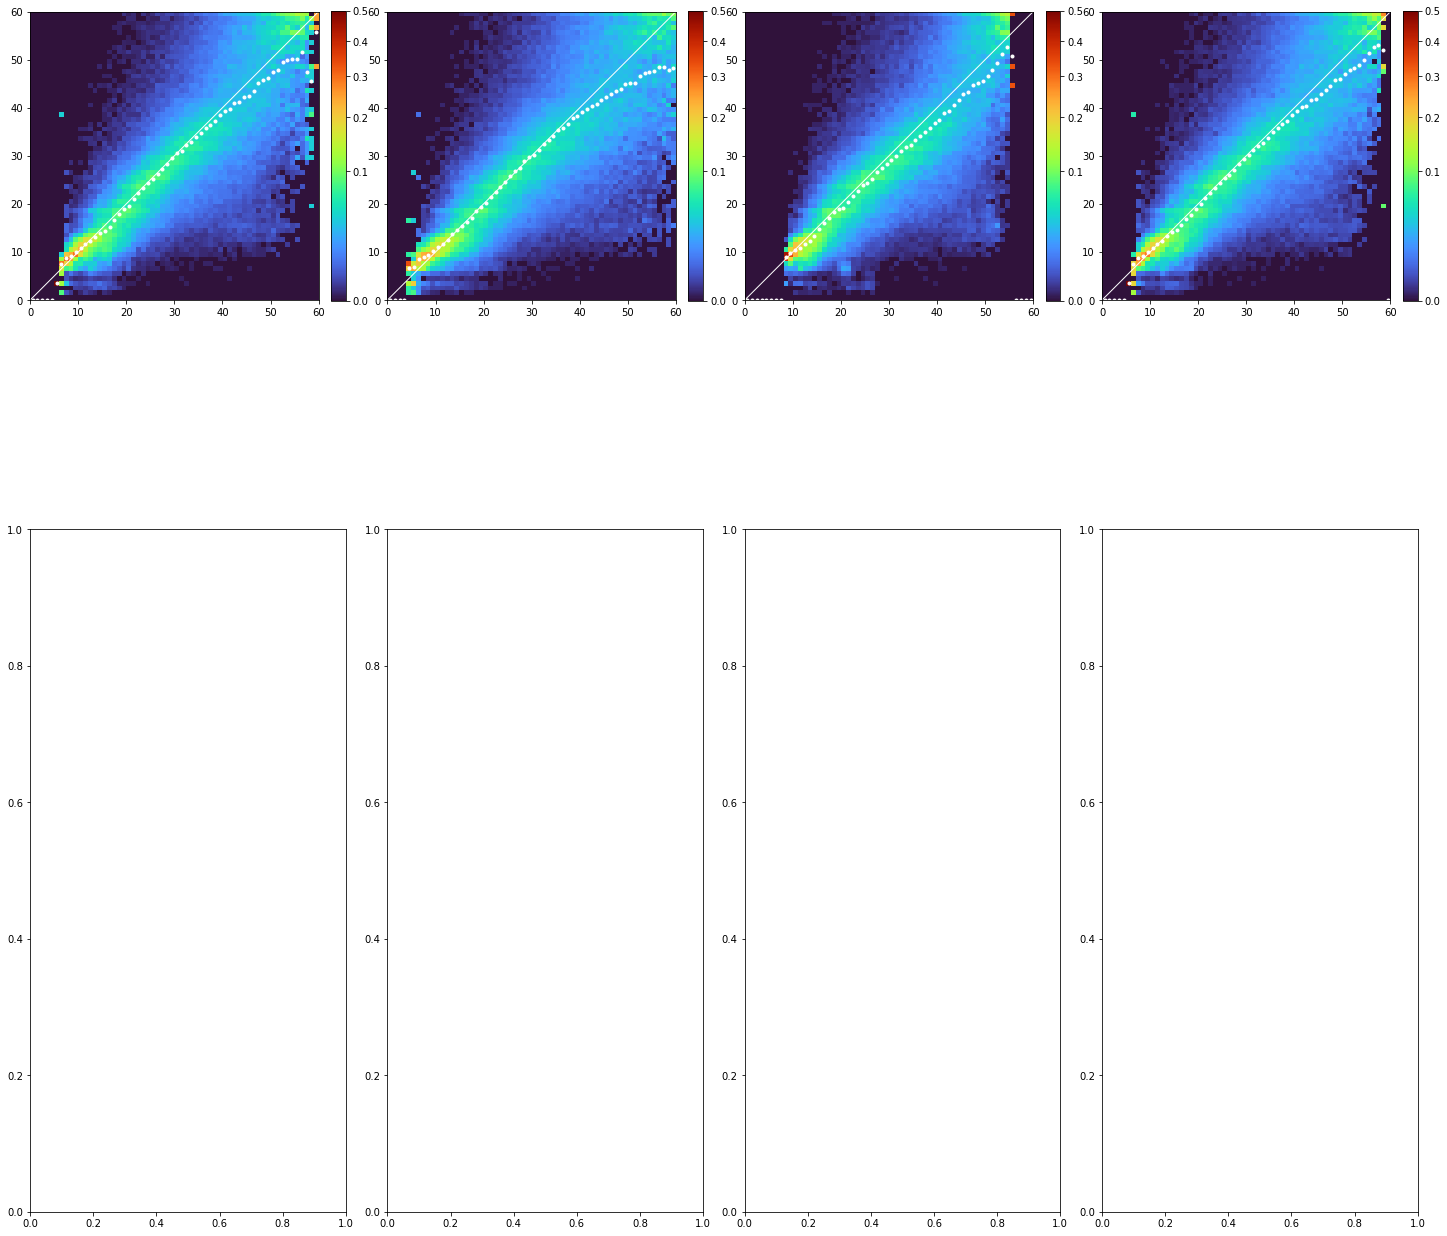

In [227]:
plotHistResultsCond(valDFang,[[0,60],[0,60]],nbins=60,gamma=0.5)

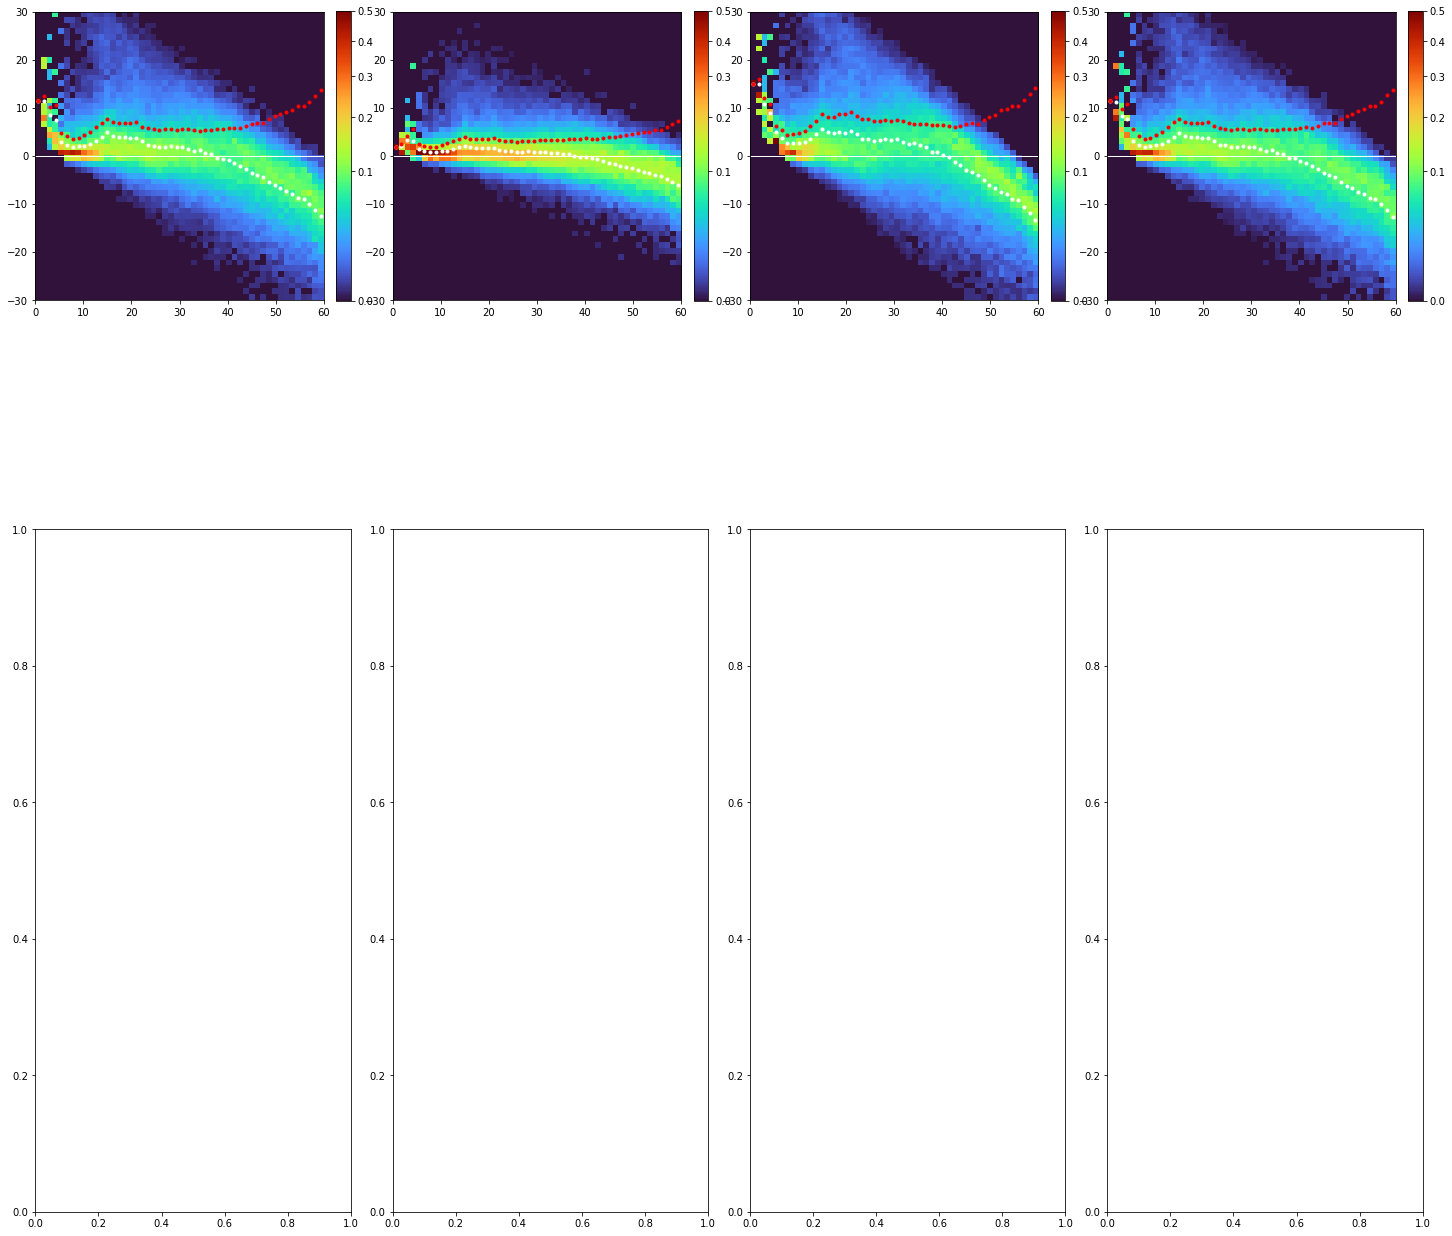

In [224]:
plotHistResidualsCond(calDFang,[[0,60],[-30,30]],50,gamma=0.5)


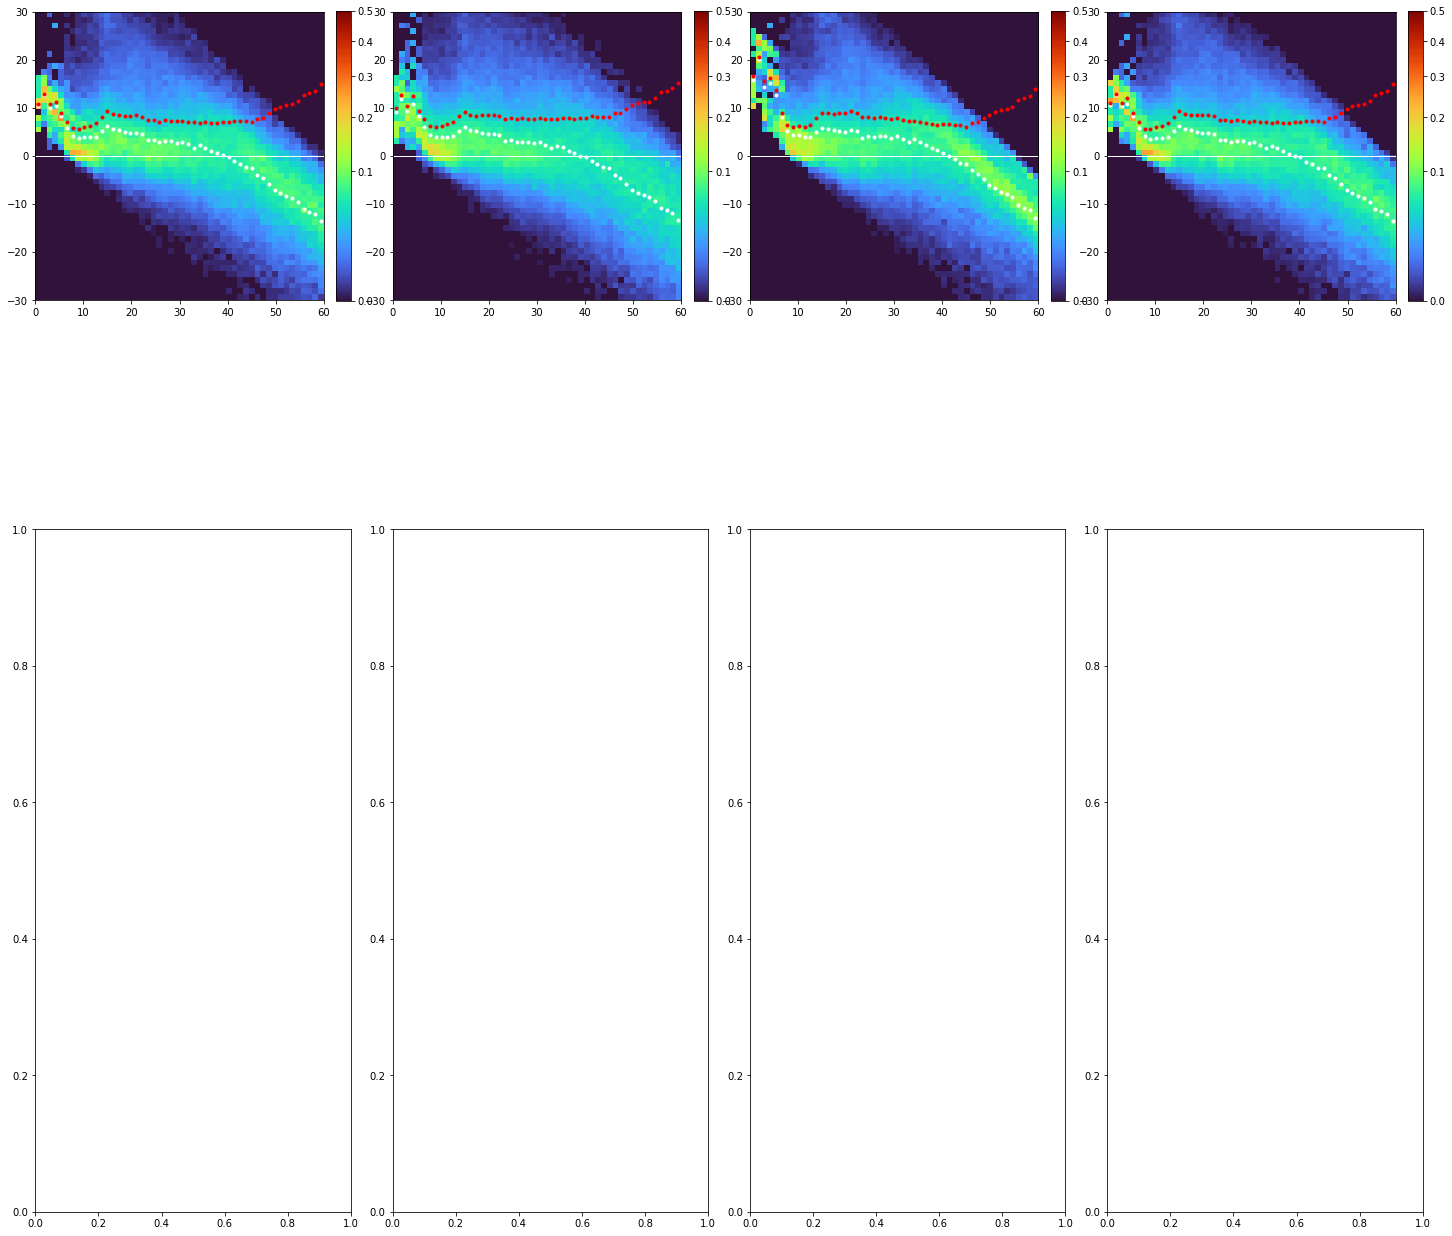

In [225]:
plotHistResidualsCond(valDFang,[[0,60],[-30,30]],nbins=50,gamma=0.5)

In [250]:
pip install earthengine-api


     |████████████████████████████████| 243 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 946 kB/s  eta 0:00:01
     |████████████████████████████████| 96 kB 8.5 MB/s  eta 0:00:01
  Created wheel for earthengine-api: filename=earthengine_api-0.1.329-py3-none-any.whl size=273050 sha256=1d99c773bc36f2c189676a83832e6862c7551b3961a13f382ee8b0075a09d9e9
  Stored in directory: /home/richard_fernandes/.cache/pip/wheels/92/2c/42/b0fb848a8640b1639cf5428dce98f0df14aefd03680b20e551
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18057 sha256=8b0db08353902d634d87d1be8df666e04c9ca5884a9e388f9c71160de7adfb92
  Stored in directory: /home/richard_fernandes/.cache/pip/wheels/cc/e7/8f/8a433809ef32e27c1f24d80effef7dde1212f72fec13df73aa
Successfully built earthengine-api httplib2shim
Note: you may need to restart the kernel to use updated packages.


In [251]:
pip install geemap 

     |████████████████████████████████| 2.1 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 76.3 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 5.3 MB/s  eta 0:00:01
     |████████████████████████████████| 3.7 MB 40.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 46.4 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 55.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 35.9 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 98 kB 3.6 MB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 51.0 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 13.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 55 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 79 kB 11.0 M

In [252]:
import ee
import geemap
from geemap import ml

In [253]:
geemap.ee_initialize()

Enter verification code:  4/1ARtbsJrfb-92uE_qiv4gJhHeMOHKVf9GY4UXU7X-KC7tkWEbzD1ZwfN1urs



Successfully saved authorization token.


In [259]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
treesRaw1 = ml.rf_to_strings(rfRaw1, rawfeatures,output_mode='REGRESSION')

In [261]:
# create a ee classifier to use with ee objects from the trees
ee_classifier_Raw1 = ml.strings_to_classifier(treesRaw1)